<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/overture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A guide to making place embeddings with Overture data
[Overture Maps](https://overturemaps.org/) is open source effort to make map features readily available for web applications (as I understand it). It includes a repository of points of interest, along with cleaned up street networks. We can use these POIs to generate embeddings based on proximity.  

In [ ]:
!pip install duckdb

In [ ]:
!pip install pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552452 sha256=7f1e4365120e7a3c982a97911b5fef412b0151aa3c5f5af70949c2a0b4e88d90
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install adjustText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pacmap

We need to set a bounding box to extract Overture data within; this could in principle be done with any country.

In [ ]:
import geopandas as gpd
# Load the Natural Earth data for countries (you can adjust the resolution as needed)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter out the United Kingdom
uk = world[world['name'] == 'United Kingdom']
# The UK's geometry consists of multiple polygons, we need to explode it and get the largest one (Great Britain)
ex = uk.explode().reset_index(drop=True)
# Assuming the largest polygon is Great Britain
gb = ex.loc[ex.geometry.area.idxmax()]

# Get the boundary and bounds of Great Britain
boundary = gb.geometry.boundary
bounds = gb.geometry.bounds

<ipython-input-6-b2be0b74dd15>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-6-b2be0b74dd15>:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ex = uk.explode().reset_index(drop=True)
<ipython-input-6-b2be0b74dd15>:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gb = ex.loc[ex.geometry.area.idxmax()]


The best way to query Overture is with `duckDB`.

In [ ]:
import duckdb
import pandas as pd

# Initialize DuckDB
con = duckdb.connect(database=':memory:')

# Load the required extensions
con.execute("INSTALL httpfs;")
con.execute("INSTALL spatial;")
con.execute("LOAD httpfs;")
con.execute("LOAD spatial;")

# Your DuckDB query to fetch data
query = """
          SELECT
            id,
            updatetime,
            version,
            CAST(names AS JSON) AS names,
            CAST(categories AS JSON) AS categories,
            confidence,
            CAST(brand AS JSON) AS brand,
            CAST(addresses AS JSON) AS addresses,
            ST_AsText(ST_GeomFromWKB(geometry)) AS geometry
          FROM
            read_parquet('s3://overturemaps-us-west-2/release/2023-11-14-alpha.0/theme=places/type=*/*', hive_partitioning=1)
          WHERE
              bbox.minx > -6.1499808414864106
              AND bbox.maxx < 1.6815307959146821
              AND bbox.miny > 49.95999990498109
              AND bbox.maxy < 58.63500010846633
        """

# Execute the query and load data into a Pandas DataFrame
df = con.execute(query).fetchdf()
df.head()

,id,updateTime,version,names,categories,confidence,brand,addresses,geometry
0,1179039698803288,2023-11-08T00:00:00.000Z,0,"{""common"":[{""value"":""Arthur's Quest"",""language...","{""main"":""landmark_and_historical_building"",""al...",0.627857,None,[],POINT (-5.7133051 50.0658607)
1,233241240773760,2023-11-08T00:00:00.000Z,0,"{""common"":[{""value"":""Cornish Coastal Path"",""la...","{""main"":""hiking_trail"",""alternate"":[""landmark_...",0.787283,None,[],POINT (-5.714477 50.0659304)
2,648481172291889,2023-11-08T00:00:00.000Z,0,"{""common"":[{""value"":""Porthcurno, Cornwall"",""la...","{""main"":""landmark_and_historical_building"",""al...",0.740240,None,[],POINT (-5.670925 50.0382518)
3,690096137797489,2023-11-08T00:00:00.000Z,0,"{""common"":[{""value"":""Carn Guthensbrâs"",""langua...","{""main"":""landmark_and_historical_building"",""al...",0.791963,None,[],POINT (-5.68333 50.03333)
4,1668347646734833,2023-11-08T00:00:00.000Z,0,"{""common"":[{""value"":""Pednvounder & Treen Beach...","{""main"":""beach"",""alternate"":[""accommodation""]}",0.903057,None,"[{""freeform"":""TR19 6LF"",""locality"":""Penzance"",...",POINT (-5.6409763 50.0499056)


In [ ]:
from shapely import wkt
gs = gpd.GeoSeries(df['geometry'].apply(wkt.loads))

In [ ]:
gf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gf.to_crs("EPSG:4326", inplace=True)

df['lon'] = gf.centroid.x
df['lat'] = gf.centroid.y

gf.to_crs("EPSG:27700", inplace=True)

df['x'] = gf.centroid.x
df['y'] = gf.centroid.y

<ipython-input-10-bc7cfd1129b8>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = gf.centroid.x
<ipython-input-10-bc7cfd1129b8>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = gf.centroid.y


In [ ]:
df.drop(['geometry'], axis=1).to_csv("drive/MyDrive/overture/gbr.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [ ]:
df = pd.read_csv("drive/MyDrive/overture/gbr.csv")

<ipython-input-3-9250b5a46cdd>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("drive/MyDrive/overture/gbr.csv")


In [ ]:
import json

In [ ]:
# We only need the first name...
def get_name(json_str):
    try:
        data = json.loads(json_str)
        return data['common'][0]['value'] if data['common'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

# Apply the function to the DataFrame
df['extracted_name'] = df['names'].apply(get_name)

In [ ]:
amenities = df[df.categories.str.contains("restaurant|cafe|bar|shop|pub|hotel")]

It uses data from OpenStreetMap (among other sources), so the names need a lot of cleaning.

In [ ]:
amenities['name'] = amenities.extracted_name.str.replace(" UK & Ireland", "")
amenities['name'] = amenities.name.str.replace(" GB", "")
amenities['name'] = amenities.name.str.replace(" UK", "")
amenities['name'] = amenities.name.str.replace(" Great Britain", "")
amenities['name'] = amenities.name.str.replace("Tesco [A-Z].*", "Tesco")
amenities['name'] = amenities.name.str.replace("Sainsbury's [A-Z].*", "Sainsbury's")
amenities['name'] = amenities.name.str.replace("Pizza Hut [A-Z].*", "Pizza Hut")
amenities['name'] = amenities.name.str.lower()

<ipython-input-15-f60b4219c81e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities['name'] = amenities.extracted_name.str.replace(" UK & Ireland", "")
<ipython-input-15-f60b4219c81e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities['name'] = amenities.name.str.replace(" GB", "")
<ipython-input-15-f60b4219c81e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
top_n = amenities.name.value_counts()
top_n = top_n[top_n > 50]

In [ ]:
chains = amenities[amenities.name.isin(top_n.index)]

In [ ]:
chains.shape[0]

42858

We will build graph embeddings from proximity: if 2 POIs are nearby, we will link them.

In [ ]:
# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(chains[['name']], geometry=gpd.points_from_xy(chains.x, chains.y))

# Step 2: Create 250m buffers
gdf['geometry'] = gdf.geometry.buffer(250)

# Step 3: Spatial join - this finds which points are within 250m of each other
joined = gpd.sjoin(gdf, gdf, how='inner', predicate='intersects')

# Step 4: Count co-occurrences - but exclude self-join
edge_counts = joined[joined['name_left'] != joined['name_right']].groupby(['name_left', 'name_right']).size().reset_index(name='count')
edge_counts.head()

,name_left,name_right,count
0,admiral slots,age,9
1,admiral slots,aldi,24
2,admiral slots,argos,8
3,admiral slots,asda,26
4,admiral slots,ask italian,11


In [ ]:
# Step 1: Sort names within each pair
edge_counts['sorted_pair'] = edge_counts.apply(lambda row: tuple(sorted([row['name_left'], row['name_right']])), axis=1)

# Step 2: Remove duplicates
edge_counts_unique = edge_counts.drop_duplicates(subset='sorted_pair')

# Drop the temporary 'sorted_pair' column and reset index
edge_counts_unique = edge_counts_unique.drop(columns='sorted_pair').reset_index(drop=True)

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_pandas_edgelist(edge_counts_unique, 'name_left', 'name_right', ['count'])

In [ ]:
from node2vec import Node2Vec

In [ ]:
n2v = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/201 [00:00<?, ?it/s]

In [ ]:
model = n2v.fit(window=10, min_count=1, batch_words=4)

In [ ]:
embed = model.wv

In [ ]:
pcmp = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0).fit_transform(embed.vectors, init="pca")

In [ ]:
# from sklearn.manifold import TSNE
# emb2d = TSNE(n_components=2).fit_transform(embed.vectors)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from adjustText import adjust_text

In [ ]:
labels = top_n.iloc[0:100]
labels = labels.index

In [ ]:
# We only need to first name...
def get_category(json_str):
    try:
        data = json.loads(json_str)
        return data['main'] if data['main'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

In [ ]:
chains['category'] = chains.categories.apply(get_category)
chains['category'] = chains.category.str.replace(".*_", "")
categories = chains.groupby(["name", "category"], as_index=False).size().sort_values("size", ascending=False).groupby("name", as_index=False).first()
categories = categories[['name', 'category']].set_index("name")

<ipython-input-35-ade63596ed8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chains['category'] = chains.categories.apply(get_category)
<ipython-input-35-ade63596ed8f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  chains['category'] = chains.category.str.replace(".*_", "")
<ipython-input-35-ade63596ed8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chains['category'] = chains.category.str.replace(".*_", "")


In [ ]:
import colorcet as cc

In [ ]:
colors = dict([(k, cc.glasbey_dark[i])for i, k in enumerate(categories.category.unique())])

crosswalk = categories.to_dict()
crosswalk = crosswalk.get('category')

crosswalk = dict([(i[0], [i[1], colors.get(i[1])]) for i in crosswalk.items()])

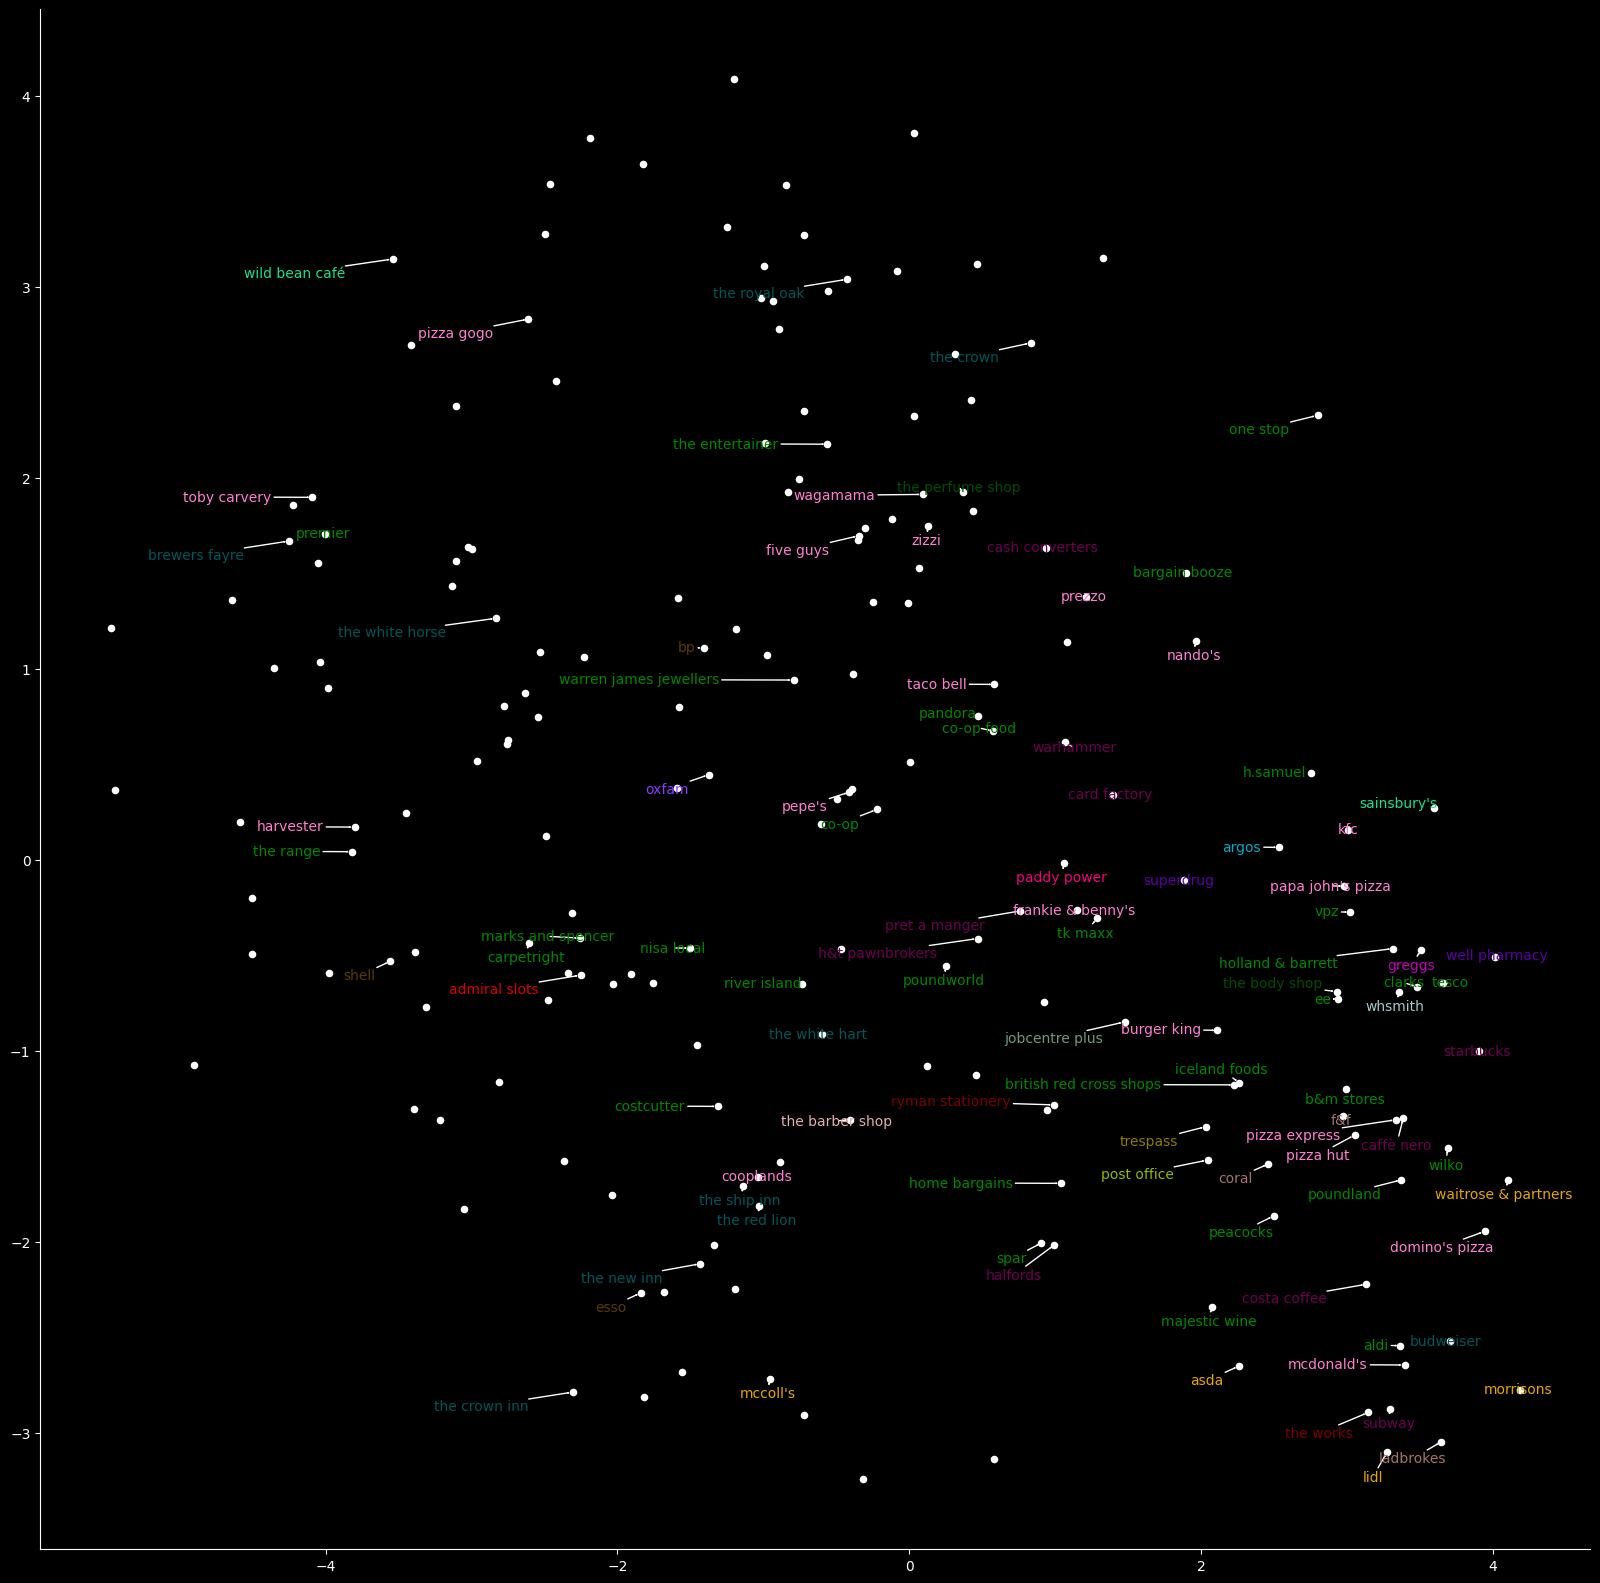

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 20), facecolor='#000000')

# Set the style
plt.style.use('dark_background')

# Scatter plot with smaller white points
ax.scatter(pcmp[:, 0], pcmp[:, 1], color='white', s=20)  # s is the size of the marker

# Customizing the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Setting axis labels
ax.set_xlabel('', fontsize=12, fontweight='bold', color='white')
ax.set_ylabel('', fontsize=12, fontweight='bold', color='white')

# Adding brand labels with adjustText
texts = []
for i, brand in enumerate(embed.index_to_key):
    if brand in labels:
      col = crosswalk.get(brand)
      texts.append(ax.text(pcmp[i, 0], pcmp[i, 1], brand, color=col[1], ha='right', va='top'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='white'))

plt.show()